# **Tải thư viện và đọc dữ liệu**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b0476ede629a91a742ea41bbe53ae26ab98629695e2df0c4ca99fbee7295257b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Import functions from pyspark.sql.functions
from pyspark.sql.functions import *

# For using window functions for aggregations or rankings
from pyspark.sql.window import Window

# For using data types when defining schemas or manipulating columns
from pyspark.sql.types import *

# Create a SparkSession, which is the entry point to programming Spark with the Dataset and DataFrame API
spark = SparkSession.builder \
    .appName("Data Cleaning with PySpark") \
    .getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_train = "/content/drive/MyDrive/BigData/W4/home-credit-default-risk/application_train.csv"

In [ ]:
print("Số dòng của train: ", train.count())
print("Số cột của train: ", len(train.columns))

Số dòng của train:  307511
Số cột của train:  122


In [ ]:
test = spark.read.csv(data_test, header = True, inferSchema = True)
test.show(20)

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+--------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

In [ ]:
print("Số dòng của test: ", test.count())
print("Số cột của test: ", len(test.columns))

Số dòng của test:  48744
Số cột của test:  121


# **Làm sạch dữ liệu**

Xử lý giá trị thiếu

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [ ]:
missing_values = train.select([F.count(F.when(F.isnan(c) | F.isnull(c) | (F.col(c) == "NULL"), c)).alias(c) for c in train.columns])
missing_values.show()

In [ ]:
# Tính tổng số lượng dòng trong dataframe
total_rows = train.count()

# Tính tỷ lệ giữa số lượng giá trị bị thiếu và tổng số lượng dòng cho mỗi cột
missing_ratios = missing_values.select([(F.col(c) / total_rows).alias(c) for c in train.columns])

# Chọn những cột có tỷ lệ giá trị bị thiếu lớn hơn 30%
columns_to_drop = []
for col_name in missing_ratios.columns:
    missing_ratio = missing_ratios.select(col_name).collect()[0][0]
    if missing_ratio > 0.3:
        columns_to_drop.append(col_name)
        print(f"Column '{col_name}' has a missing ratio of {missing_ratio:.2%}")

In [ ]:
# Loại bỏ các cột từ DataFrame
train = train.drop(*columns_to_drop)

In [ ]:
# Kiểm tra lại số cột, trước đó là 122, sau là 72
print("Số cột: ", len(train.columns))

In [ ]:
missing_values_percentage = train.agg(*[
    (1 - (count(c) / count('*'))).alias(c + '_missing_percentage')
    for c in train.columns
])

# Chọn ra những cột có tỉ lệ giá trị bị thiếu dưới 20%
selected_columns = [
    c for c in missing_values_percentage.columns
    if missing_values_percentage.select(c).first()[0] < 0.2
]

# In ra các cột được chọn
print("Các cột có tỉ lệ giá trị bị thiếu dưới 20%:")
print(selected_columns)

In [ ]:
train.show()

In [ ]:
# Loại bỏ các cột sau vì không có thông tin hữu ích
trash = ["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4","FLAG_DOCUMENT_5","FLAG_DOCUMENT_6",
         "FLAG_DOCUMENT_7","FLAG_DOCUMENT_8","FLAG_DOCUMENT_9","FLAG_DOCUMENT_10","FLAG_DOCUMENT_11",
         "FLAG_DOCUMENT_12","FLAG_DOCUMENT_13","FLAG_DOCUMENT_14","FLAG_DOCUMENT_15","FLAG_DOCUMENT_16",
         "FLAG_DOCUMENT_17","FLAG_DOCUMENT_18","FLAG_DOCUMENT_19","FLAG_DOCUMENT_20","FLAG_DOCUMENT_21",
         "CODE_GENDER","CNT_CHILDREN","NAME_TYPE_SUITE","NAME_FAMILY_STATUS","REGION_POPULATION_RELATIVE",
         "DAYS_EMPLOYED","DAYS_REGISTRATION","DAYS_ID_PUBLISH","OWN_CAR_AGE","FLAG_EMP_PHONE","FLAG_WORK_PHONE",
         "FLAG_PHONE","CNT_FAM_MEMBERS","WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START","REG_REGION_NOT_WORK_REGION",
         "LIVE_REGION_NOT_WORK_REGION","LIVE_CITY_NOT_WORK_CITY","ORGANIZATION_TYPE","APARTMENTS_AVG","BASEMENTAREA_AVG",
         "YEARS_BEGINEXPLUATATION_AVG","YEARS_BUILD_AVG","COMMONAREA_AVG","ELEVATORS_AVG","ENTRANCES_AVG","FLOORSMAX_AVG",
         "FLOORSMIN_AVG","LANDAREA_AVG","LIVINGAPARTMENTS_AVG","LIVINGAREA_AVG","NONLIVINGAPARTMENTS_AVG","NONLIVINGAREA_AVG",
         "APARTMENTS_MODE","BASEMENTAREA_MODE","YEARS_BEGINEXPLUATATION_MODE","YEARS_BUILD_MODE","COMMONAREA_MODE","ELEVATORS_MODE",
         "ENTRANCES_MODE","FLOORSMAX_MODE","FLOORSMIN_MODE","LANDAREA_MODE","LIVINGAPARTMENTS_MODE"]

In [ ]:
train = train.drop(*trash)

In [ ]:
# Tạo số tiền vay trên giá trị tài sản
train = train.withColumn("CREDIT_GOODS_PRICE_RATIO", train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"])

In [ ]:
# Tạo tổng thu nhập hàng năm
train = train.withColumn("ANNUAL_INCOME", train["AMT_INCOME_TOTAL"] * 365)

In [ ]:
# Tạo cột khoảng thời gian làm việc
train = train.withColumn("YEARS_EMPLOYED", floor(abs(train["DAYS_EMPLOYED"]) / 365))

In [ ]:
# Tạo cột AGE từ DAYS_BIRTH
train = train.withColumn("AGE", floor(abs(train["DAYS_BIRTH"]) / 365))

In [ ]:
train.show()

In [ ]:
print("Số cột: ", len(train.columns))

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=804cd8d3821e261583388d4abfee26c32d69a66f3ec476b2d459faf73e409f51
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
temp_output_path = "/content/temp_clean_data"

# Xuất DataFrame ra tệp CSV
train.coalesce(1).write.csv(temp_output_path, header=True, mode='overwrite')

# Kiểm tra thư mục tạm thời để đảm bảo tệp đã được tạo
import os
print(os.listdir(temp_output_path))

# Tìm tệp CSV thực sự trong thư mục xuất ra và đổi tên tệp
import shutil
for file in os.listdir(temp_output_path):
    if file.startswith("part-00000"):
        shutil.move(os.path.join(temp_output_path, file), "/content/clean_data.csv")

# Tải tệp xuống
from google.colab import files
files.download("/content/clean_data.csv")

# **Chạy file bắt đầu từ đây với file clean_data.csv đã được lưu ở bên trên.**
# 

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=95c19deff9c0c7c7212315483586f0f3c3bc973e21caf3b07016affe8370d24e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Import functions from pyspark.sql.functions
from pyspark.sql.functions import *

# For using window functions for aggregations or rankings
from pyspark.sql.window import Window

# For using data types when defining schemas or manipulating columns
from pyspark.sql.types import *

# Create a SparkSession, which is the entry point to programming Spark with the Dataset and DataFrame API
spark = SparkSession.builder
    .appName("Data Cleaning with PySpark") \
    .getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
link_clean_data = "/content/drive/MyDrive/BigData/W7/clean_data.csv"

In [ ]:
#df = spark.read.csv("clean_data.csv", header = True, inferSchema = True)
#df.show(10)
df = spark.read.csv(link_clean_data, header = True, inferSchema = True)
df.show(10)

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+--------------------+--------------------+-----------------+----------+----------+----------------+----------+--------------------+---------------------------+--------------------------+----------------------+----------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+----------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|DAYS_BIRTH|FLAG_MOBIL|FLAG_CONT_MOBILE|FLAG_EMAIL|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|REG_REGION_NOT_LIVE_REGION|REG_CITY_NOT_

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Hiển thị kết quả
null_counts.show()

# Chuyển kết quả thành DataFrame
null_counts_dict = null_counts.collect()[0].asDict()

# Lọc các cột có giá trị null nhiều hơn 0
columns_with_nulls = {k: v for k, v in null_counts_dict.items() if v > 0}

# Hiển thị kết quả
for column, count in columns_with_nulls.items():
    print(f"Cột {column} có {count} giá trị null")

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+----------------+-------------------+-----------------+----------+----------+----------------+----------+--------------------+---------------------------+--------------------------+----------------------+----------------------+------------+------------+------------------------+------------------------+------------------------+------------------------+----------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|DAYS_BIRTH|FLAG_MOBIL|FLAG_CONT_MOBILE|FLAG_EMAIL|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|REG_REGION_NOT_LIVE_REGION|REG_CITY_NOT_LIVE_CITY|REG_CITY_NOT_W

Xử lý các giá trị bị Null cho các cột AMT_REQ_CREDIT_BUREAU_

Tại vì chứa Null, có thể là họ chưa check thẻ tín dụng bao giờ. Do đó thay thế giá trị Null là 0.

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_HOUR").count().show()

+--------------------------+------+
|AMT_REQ_CREDIT_BUREAU_HOUR| count|
+--------------------------+------+
|                       0.0|264366|
|                      NULL| 41519|
|                       1.0|  1560|
|                       4.0|     1|
|                       3.0|     9|
|                       2.0|    56|
+--------------------------+------+



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_HOUR",
                   col("AMT_REQ_CREDIT_BUREAU_HOUR").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_HOUR": 0})

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_DAY").count().show()

+-------------------------+------+
|AMT_REQ_CREDIT_BUREAU_DAY| count|
+-------------------------+------+
|                      8.0|     1|
|                      0.0|264503|
|                     NULL| 41519|
|                      1.0|  1292|
|                      4.0|    26|
|                      3.0|    45|
|                      2.0|   106|
|                      6.0|     8|
|                      5.0|     9|
|                      9.0|     2|
+-------------------------+------+



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_DAY",
                   col("AMT_REQ_CREDIT_BUREAU_DAY").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_DAY": 0})

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_WEEK").count().show()

+--------------------------+------+
|AMT_REQ_CREDIT_BUREAU_WEEK| count|
+--------------------------+------+
|                       8.0|     5|
|                       0.0|257456|
|                      NULL| 41519|
|                       1.0|  8208|
|                       4.0|    34|
|                       3.0|    58|
|                       2.0|   199|
|                       6.0|    20|
|                       5.0|    10|
|                       7.0|     2|
+--------------------------+------+



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_WEEK",
                   col("AMT_REQ_CREDIT_BUREAU_WEEK").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_WEEK": 0})

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_MON").count().show()

+-------------------------+------+
|AMT_REQ_CREDIT_BUREAU_MON| count|
+-------------------------+------+
|                      8.0|   185|
|                      0.0|222233|
|                      7.0|   298|
|                     NULL| 41519|
|                     18.0|     6|
|                      1.0| 33147|
|                      4.0|  1076|
|                     23.0|     1|
|                     11.0|   119|
|                     14.0|    40|
|                      3.0|  1991|
|                     19.0|     3|
|                      2.0|  5386|
|                     17.0|    14|
|                     10.0|   132|
|                     13.0|    72|
|                      6.0|   343|
|                      5.0|   602|
|                     24.0|     1|
|                     15.0|    35|
+-------------------------+------+
only showing top 20 rows



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_MON",
                   col("AMT_REQ_CREDIT_BUREAU_MON").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_MON": 0})

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_QRT").count().show()

+-------------------------+------+
|AMT_REQ_CREDIT_BUREAU_QRT| count|
+-------------------------+------+
|                      8.0|     7|
|                      0.0|215417|
|                      7.0|     7|
|                     NULL| 41519|
|                      1.0| 33862|
|                      4.0|   476|
|                      3.0|  1717|
|                      2.0| 14412|
|                      6.0|    28|
|                      5.0|    64|
|                     19.0|     1|
|                    261.0|     1|
+-------------------------+------+



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_QRT",
                   col("AMT_REQ_CREDIT_BUREAU_QRT").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_QRT": 0})

In [ ]:
df.groupBy("AMT_REQ_CREDIT_BUREAU_YEAR").count().show()

+--------------------------+-----+
|AMT_REQ_CREDIT_BUREAU_YEAR|count|
+--------------------------+-----+
|                       8.0| 2127|
|                       0.0|71801|
|                       7.0| 3869|
|                      NULL|41519|
|                      18.0|    4|
|                       1.0|63405|
|                      25.0|    1|
|                       4.0|20714|
|                      23.0|    1|
|                      11.0|   31|
|                      21.0|    1|
|                      14.0|   10|
|                      22.0|    1|
|                       3.0|33628|
|                      19.0|    4|
|                       2.0|50192|
|                      17.0|    7|
|                      10.0|   22|
|                      13.0|   19|
|                       6.0| 6967|
+--------------------------+-----+
only showing top 20 rows



In [ ]:
df = df.withColumn("AMT_REQ_CREDIT_BUREAU_YEAR",
                   col("AMT_REQ_CREDIT_BUREAU_YEAR").cast("double"))

df = df.fillna({"AMT_REQ_CREDIT_BUREAU_YEAR": 0})

Xử lý các giá trị Null tại cột AMT_ANNUITY( AMT_ANNUITY là số tiền mà người vay phải trả hàng tháng cho khoản vay của mình )

Null ở đây có thể là họ chưa từng vay, nên không có số tiền người đó phải trả hàng tháng cho khoản vay của họ.

Do đó sẽ thay thế Null bằng giá trị 0.

In [ ]:
df = df.withColumn("AMT_ANNUITY", col("AMT_ANNUITY").cast("double"))

# Thay thế các giá trị Null trong cột AMT_ANNUITY thành 0
df = df.fillna({"AMT_ANNUITY": 0})

Xử lý các giá trị Null của cột AMT_GOODS_PRICE ( Cột "AMT_GOODS_PRICE" trong dữ liệu thường đề cập đến giá của mặt hàng được mua bằng khoản vay, chẳng hạn như giá của căn hộ, xe hơi, hoặc bất kỳ tài sản nào khác mà khoản vay được sử dụng để mua. )

Ở đây, người vay không đề cập gì đến giá trị của món hàng được mua bằng khoản vay.

Do đó sẽ bỏ những dòng chứa giá trị Null ( 278 giá trị )

In [ ]:
df = df.na.drop(subset=["AMT_GOODS_PRICE"])

Xử lý các giá trị Null tại cột EXT_SOURCE_2,3

EXT_SOURCE_2,3 là điểm số được chuẩn hóa từ nguồn dữ liệu bên ngoài. Dao động từ 0-1, điểm càng lớn có thể khả năng trả được nợ (uy tín) càng cao.

EXT_SOURCE_2 có 660 giá trị Null

EXT_SOURCE_3 có 60965 giá trị Null

Gía trị Null ở đây có thể là người đó chưa đi chuẩn hóa điểm. Nên không thể biết người đó có uy tín hay không. Nên đối với EXT_SOURCE_2 (660 giá trị Null) thì sẽ bỏ những dòng Null. Còn đối với EXT_SOURCE_3 thì bỏ cột vì giá trị thiếu quá nhiều.

In [ ]:
df = df.na.drop(subset=["EXT_SOURCE_2"])
df = df.drop("EXT_SOURCE_3")

Xử lý các giá trị Null tại CNT_SOCIAL_CIRCLE (Số lần vi phạm của môi trường xã hội của khách hàng với 30 ngày trễ hạn (days past due))

Đối với những giá trị Null tại cột này sẽ bỏ những dòng Null đi, bởi vì dữ liệu bị Null ít ( 1021 giá trị null ) và 1 phần vì cũng không phân tích được là nên thay bằng giá trị nào khác.

# **Và loại bỏ các biến không cần thiết**

In [ ]:
df.groupBy("DEF_30_CNT_SOCIAL_CIRCLE").count().show()

+------------------------+------+
|DEF_30_CNT_SOCIAL_CIRCLE| count|
+------------------------+------+
|                     0.0|270489|
|                     7.0|     1|
|                    NULL|  1017|
|                     1.0| 28250|
|                    34.0|     1|
|                     4.0|   252|
|                     3.0|  1188|
|                     2.0|  5308|
|                     6.0|    11|
|                     5.0|    56|
|                     8.0|     1|
+------------------------+------+



In [ ]:
df = df.na.drop(subset=["DEF_30_CNT_SOCIAL_CIRCLE"])
df = df.drop("OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "DAYS_BIRTH", "FLAG_MOBIL",
             "FLAG_EMAIL", "REGION_RATING_CLIENT", "REG_REGION_NOT_LIVE_REGION", "REG_CITY_NOT_WORK_CITY", "DAYS_LAST_PHONE_CHANGE")

In [ ]:
print("Số dòng của train: ", df.count())
print("Số cột của train: ", len(df.columns))

Số dòng của train:  305557
Số cột của train:  23


In [ ]:
# null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Hiển thị kết quả
# null_counts.show()

# Chuyển kết quả thành DataFrame
# null_counts_dict = null_counts.collect()[0].asDict()

# Lọc các cột có giá trị null nhiều hơn 0
# columns_with_nulls = {k: v for k, v in null_counts_dict.items() if v > 0}

# Hiển thị kết quả
# for column, count in columns_with_nulls.items():
#    print(f"Cột {column} có {count} giá trị null")

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+--------------------+--------------------+-----------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|
+----------+------+------------------+------------+---------------+----------------+----

In [ ]:
df.groupBy("TARGET").count().show()

+------+------+
|TARGET| count|
+------+------+
|     1| 24716|
|     0|280841|
+------+------+



In [ ]:
df.describe().show()

+-------+------------------+-------------------+------------------+------------+---------------+------------------+-----------------+-----------------+-----------------+----------------+--------------------+-----------------+--------------------+---------------------------+----------------------+--------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|summary|        SK_ID_CURR|             TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|  AMT_INCOME_TOTAL|       AMT_CREDIT|      AMT_ANNUITY|  AMT_GOODS_PRICE|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|    FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|        EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_

Chuyển đổi kiểu, mã hóa cho các biến để đưa vào mô hình

In [ ]:
df.dtypes

[('SK_ID_CURR', 'int'),
 ('TARGET', 'int'),
 ('NAME_CONTRACT_TYPE', 'string'),
 ('FLAG_OWN_CAR', 'string'),
 ('FLAG_OWN_REALTY', 'string'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('NAME_INCOME_TYPE', 'string'),
 ('NAME_EDUCATION_TYPE', 'string'),
 ('NAME_HOUSING_TYPE', 'string'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('REG_CITY_NOT_LIVE_CITY', 'int'),
 ('EXT_SOURCE_2', 'double'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_MON', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 'double')]

In [ ]:
df.groupBy("NAME_CONTRACT_TYPE").count().show()

+------------------+------+
|NAME_CONTRACT_TYPE| count|
+------------------+------+
|   Revolving loans| 27925|
|        Cash loans|277632|
+------------------+------+



In [ ]:
# Chuyển "Revolving loans" thành 0 và "Cash loan" thành 1
df = df.withColumn("NAME_CONTRACT_TYPE", when(df["NAME_CONTRACT_TYPE"] == "Revolving loans", 0).otherwise(1))


In [ ]:
df.groupBy("FLAG_OWN_CAR").count().show()

+------------+------+
|FLAG_OWN_CAR| count|
+------------+------+
|           Y|104038|
|           N|201519|
+------------+------+



In [ ]:
# Chuyển N thành 0 và Y thành 1
df = df.withColumn("FLAG_OWN_CAR", when(df["FLAG_OWN_CAR"] == "Y", 1).otherwise(0))

In [ ]:
df.groupBy("FLAG_OWN_REALTY").count().show()

+---------------+------+
|FLAG_OWN_REALTY| count|
+---------------+------+
|              Y|211887|
|              N| 93670|
+---------------+------+



In [ ]:
# Chuyển N thành 0 và Y thành 1
df = df.withColumn("FLAG_OWN_REALTY", when(df["FLAG_OWN_REALTY"] == "Y", 1).otherwise(0))

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+--------------------+--------------------+-----------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|
+----------+------+------------------+------------+---------------+----------------+----

In [ ]:
# Tại cột "NAME_INCOME_TYPE", e sẽ sắp xếp chúng theo bảng chữ cái, rồi gán giá trị từ 0,1
income_type_mapping = {
    "Businessman": 0,
    "Commercial associate": 1,
    "Maternity leave": 2,
    "Pensioner": 3,
    "State servant": 4,
    "Student": 5,
    "Unemployed": 6,
    "Working": 7
}
df = df.withColumn("Income_Type_Index",
                   when(df["NAME_INCOME_TYPE"] == "Businessman", 0)
                   .when(df["NAME_INCOME_TYPE"] == "Commercial associate", 1)
                   .when(df["NAME_INCOME_TYPE"] == "Maternity leave", 2)
                   .when(df["NAME_INCOME_TYPE"] == "Pensioner", 3)
                   .when(df["NAME_INCOME_TYPE"] == "State servant", 4)
                   .when(df["NAME_INCOME_TYPE"] == "Student", 5)
                   .when(df["NAME_INCOME_TYPE"] == "Unemployed", 6)
                   .when(df["NAME_INCOME_TYPE"] == "Working", 7)
                   .otherwise(None))
df = df.drop("NAME_INCOME_TYPE")

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+--------------------+-----------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-----------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE| NAME_EDUCATION_TYPE|NAME_HOUSING_TYPE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|Income_Type_Index|
+----------+------+------------------+------------+---------------+----------------+----------

In [ ]:
df.groupBy("NAME_EDUCATION_TYPE").count().show()

+--------------------+------+
| NAME_EDUCATION_TYPE| count|
+--------------------+------+
|     Academic degree|   164|
|   Incomplete higher| 10201|
|Secondary / secon...|217192|
|     Lower secondary|  3794|
|    Higher education| 74206|
+--------------------+------+



In [ ]:
# Sắp xếp theo cấp bậc học vấn, từ thấp đến cao
df = df.withColumn("NAME_EDUCATION_TYPE_INDEX",
                   when(df["NAME_EDUCATION_TYPE"] == "Lower secondary", 0)
                   .when(df["NAME_EDUCATION_TYPE"] == "Secondary / secondary special", 1)
                   .when(df["NAME_EDUCATION_TYPE"] == "Incomplete higher", 2)
                   .when(df["NAME_EDUCATION_TYPE"] == "Higher education", 3)
                   .when(df["NAME_EDUCATION_TYPE"] == "Academic degree", 4)
                   .otherwise(None))
df = df.drop("NAME_EDUCATION_TYPE")

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+-----------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-----------------+-------------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_HOUSING_TYPE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|Income_Type_Index|NAME_EDUCATION_TYPE_INDEX|
+----------+------+------------------+------------+---------------+----------------+

In [ ]:
df.groupBy('NAME_HOUSING_TYPE').count().show(10)

+-------------------+------+
|  NAME_HOUSING_TYPE| count|
+-------------------+------+
|  House / apartment|271168|
|Municipal apartment| 11099|
|    Co-op apartment|  1111|
|   Rented apartment|  4843|
|   Office apartment|  2595|
|       With parents| 14741|
+-------------------+------+



In [ ]:
# Gán "House / apartment" thành 1 và các giá trị khác còn lại bằng 0
# Bởi vì, "House / apartment" là "Nhà riêng / Căn hộ chung cư", còn lại là nhà thuê, ở với gia đình, tập thể, ...
df = df.withColumn("NAME_HOUSING_TYPE_INDEX",
                   when(df["NAME_HOUSING_TYPE"] == "House / apartment", 1)
                   .when(df["NAME_HOUSING_TYPE"] == "Municipal apartment", 0)
                   .when(df["NAME_HOUSING_TYPE"] == "Co-op apartment", 0)
                   .when(df["NAME_HOUSING_TYPE"] == "Rented apartment", 0)
                   .when(df["NAME_HOUSING_TYPE"] == "Office apartment", 0)
                   .when(df["NAME_HOUSING_TYPE"] == "With parents", 0)
                   .otherwise(df["NAME_HOUSING_TYPE"]))
df = df.drop("NAME_HOUSING_TYPE")

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-----------------+-------------------------+-----------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|Income_Type_Index|NAME_EDUCATION_TYPE_INDEX|NAME_HOUSING_TYPE_INDEX|
+----------+------+------------------+------------+---------------+-----

In [ ]:
df.dtypes

[('SK_ID_CURR', 'int'),
 ('TARGET', 'int'),
 ('NAME_CONTRACT_TYPE', 'int'),
 ('FLAG_OWN_CAR', 'int'),
 ('FLAG_OWN_REALTY', 'int'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('REG_CITY_NOT_LIVE_CITY', 'int'),
 ('EXT_SOURCE_2', 'double'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_MON', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 'double'),
 ('Income_Type_Index', 'int'),
 ('NAME_EDUCATION_TYPE_INDEX', 'int'),
 ('NAME_HOUSING_TYPE_INDEX', 'string')]

In [ ]:
# Chuyển "NAME_HOUSING_TYPE_INDEX" từ string sang int
df = df.withColumn("NAME_HOUSING_TYPE_INDEX", df["NAME_HOUSING_TYPE_INDEX"].cast(IntegerType()))


In [ ]:
df.dtypes

[('SK_ID_CURR', 'int'),
 ('TARGET', 'int'),
 ('NAME_CONTRACT_TYPE', 'int'),
 ('FLAG_OWN_CAR', 'int'),
 ('FLAG_OWN_REALTY', 'int'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('REG_CITY_NOT_LIVE_CITY', 'int'),
 ('EXT_SOURCE_2', 'double'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_MON', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 'double'),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 'double'),
 ('Income_Type_Index', 'int'),
 ('NAME_EDUCATION_TYPE_INDEX', 'int'),
 ('NAME_HOUSING_TYPE_INDEX', 'int')]

In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-----------------+-------------------------+-----------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|Income_Type_Index|NAME_EDUCATION_TYPE_INDEX|NAME_HOUSING_TYPE_INDEX|
+----------+------+------------------+------------+---------------+-----

In [ ]:
print("Số dòng: ", df.count())
print("Số cột: ", len(df.columns))

Số dòng:  305557
Số cột:  23


In [ ]:
df.show()

+----------+------+------------------+------------+---------------+----------------+----------+-----------+---------------+----------------+---------------------------+----------------------+-------------------+------------------------+--------------------------+-------------------------+--------------------------+-------------------------+-------------------------+--------------------------+-----------------+-------------------------+-----------------------+
|SK_ID_CURR|TARGET|NAME_CONTRACT_TYPE|FLAG_OWN_CAR|FLAG_OWN_REALTY|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|FLAG_CONT_MOBILE|REGION_RATING_CLIENT_W_CITY|REG_CITY_NOT_LIVE_CITY|       EXT_SOURCE_2|DEF_30_CNT_SOCIAL_CIRCLE|AMT_REQ_CREDIT_BUREAU_HOUR|AMT_REQ_CREDIT_BUREAU_DAY|AMT_REQ_CREDIT_BUREAU_WEEK|AMT_REQ_CREDIT_BUREAU_MON|AMT_REQ_CREDIT_BUREAU_QRT|AMT_REQ_CREDIT_BUREAU_YEAR|Income_Type_Index|NAME_EDUCATION_TYPE_INDEX|NAME_HOUSING_TYPE_INDEX|
+----------+------+------------------+------------+---------------+-----

# **Build Logistic Regression**

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
selected_features = ["NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "AMT_INCOME_TOTAL",
                    "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "FLAG_CONT_MOBILE", "REGION_RATING_CLIENT_W_CITY",
                    "REG_CITY_NOT_LIVE_CITY", "EXT_SOURCE_2", "DEF_30_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR",
                    "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT",
                    "AMT_REQ_CREDIT_BUREAU_YEAR", "Income_Type_Index", "NAME_EDUCATION_TYPE_INDEX", "NAME_HOUSING_TYPE_INDEX"]
label = "TARGET"

In [ ]:
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.regression import LinearRegression
#from pyspark.ml import Pipeline
#from pyspark.ml.evaluation import RegressionEvaluator
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#import builtins
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80% huấn luyện, 20% kiểm tra)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Chuyển đổi dữ liệu Spark DataFrame thành Pandas DataFrame
train_data_pandas = train_data.toPandas()

# Tách đặc trưng và nhãn
X = train_data_pandas[selected_features]
y = train_data_pandas["TARGET"]

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

max_samples = 150000
if len(X_resampled) > max_samples:
    indices = np.random.choice(len(X_resampled), max_samples, replace=False)
    X_resampled = X_resampled.iloc[indices]  # Sử dụng .iloc để truy cập các hàng dựa trên chỉ mục vị trí
    y_resampled = y_resampled.iloc[indices]
# Chuyển đổi lại thành Spark DataFrame
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)
train_data_balanced = spark.createDataFrame(resampled_data)

In [ ]:
# Khởi tạo các StringIndexer cho các cột phân loại
indexers = [StringIndexer(inputCol=column, outputCol=column + "_INDEX") for column in ["NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]]

# Danh sách các cột đặc trưng đã được mã hóa
indexed_features = [column + "_INDEX" for column in ["NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]]
selected_feature_index = [col for col in selected_features if col not in ["NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]] + indexed_features

In [ ]:
# Khởi tạo VectorAssembler
assembler = VectorAssembler(inputCols=selected_feature_index, outputCol="features")

In [ ]:
# Khởi tạo LogisticRegression
lr = LogisticRegression(labelCol="TARGET", featuresCol="features")

# Tạo danh sách các stages trong pipeline
stages = indexers + [assembler, lr]

In [ ]:
# Khởi tạo Pipeline
pipeline = Pipeline(stages=stages)


In [ ]:
# Huấn luyện mô hình trên tập train_data_balanced
model = pipeline.fit(train_data_balanced)


In [ ]:
# Dự đoán trên tập test_data
predictions = model.transform(test_data)

In [ ]:
# Tính toán AUC
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"AUC: {auc}")

AUC: 0.6168146578434393


In [ ]:
# Tính toán các chỉ số
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")

f1 = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.7557928569790492
Precision: 0.8701440612619059
Recall: 0.6867148652185292


In [ ]:
# Chuyển đổi dự đoán và nhãn thực sự thành Pandas DataFrame
predictions_pandas = predictions.select("prediction", "TARGET").toPandas()

In [ ]:
# Tính toán ma trận nhầm lẫn
conf_matrix = confusion_matrix(predictions_pandas["TARGET"], predictions_pandas["prediction"])
# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[39710 16456]
 [ 2697  2273]]


In [ ]:
train_data.groupBy("TARGET").count().show()

+------+------+
|TARGET| count|
+------+------+
|     1| 19746|
|     0|224675|
+------+------+



In [ ]:
train_data_balanced.groupBy("TARGET").count().show()

+------+-----+
|TARGET|count|
+------+-----+
|     0|74906|
|     1|75094|
+------+-----+



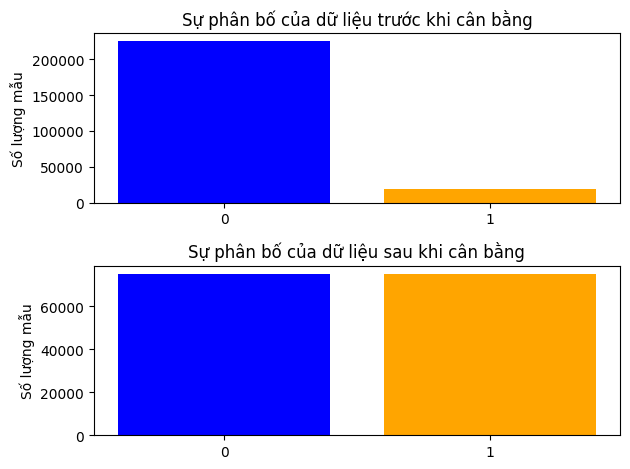

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu trước khi cân bằng
labels_before = ['0', '1']
counts_before = [224675, 19746]

# Dữ liệu sau khi cân bằng
labels_after = ['0', '1']
counts_after = [74978, 75022]

# Vẽ biểu đồ
fig, axs = plt.subplots(2)

# Biểu đồ trước khi cân bằng
axs[0].bar(labels_before, counts_before, color=['blue', 'orange'])
axs[0].set_title('Sự phân bố của dữ liệu trước khi cân bằng')
axs[0].set_ylabel('Số lượng mẫu')

# Biểu đồ sau khi cân bằng
axs[1].bar(labels_after, counts_after, color=['blue', 'orange'])
axs[1].set_title('Sự phân bố của dữ liệu sau khi cân bằng')
axs[1].set_ylabel('Số lượng mẫu')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

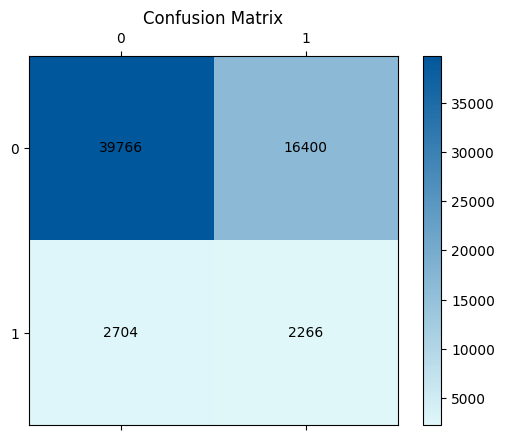

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Ma trận nhầm lẫn
confusion_matrix = np.array([[39766, 16400], [2704, 2266]])

# Tạo figure và axes
fig, ax = plt.subplots()

# Vẽ ma trận nhầm lẫn
cmap = LinearSegmentedColormap.from_list('custom_blue', ['#e0f7fa', '#01579b'])

cax = ax.matshow(confusion_matrix, cmap=cmap)

# Thêm tiêu đề và chú thích
plt.title('Confusion Matrix')
plt.xlabel('')
plt.ylabel('')
plt.colorbar(cax)

# Hiển thị giá trị trong từng ô
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center')

# Hiển thị
plt.show()